Trước khi run pip, cài đặt các thư viện bằng câu lệnh sau
```
pip install pandas numpy matplotlib scikit-learn keras tensorflow xgboost
```

In [1]:
import MetaTrader5 as mt
import pandas as pd
from datetime import datetime

mt.initialize()

login = 84193298
password = "-8WyMrVz"
server = "MetaQuotes-Demo"

mt.login(login, password, server)

def get_data_FX(symbol, timeframe, rows):
    ohlc_data = pd.DataFrame(mt.copy_rates_from_pos(symbol, timeframe, 0, rows))
    ohlc_data['time'] = ohlc_data.apply(lambda x: datetime.fromtimestamp(x["time"]), axis=1)
    ohlc_data = ohlc_data.rename(columns={'time': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'real_volume': 'Volume'})
    ohlc_data.set_index("Date")
    return ohlc_data

df = get_data_FX('EURUSD', mt.TIMEFRAME_H1,1000)
#df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Close,tick_volume,spread,Volume
0,2024-05-16 23:00:00,1.08633,1.08668,1.08546,1.08559,2655,0,0
1,2024-05-17 00:00:00,1.08560,1.08703,1.08544,1.08702,2471,0,0
2,2024-05-17 01:00:00,1.08703,1.08757,1.08667,1.08751,1675,0,0
3,2024-05-17 02:00:00,1.08750,1.08753,1.08699,1.08734,1292,0,0
4,2024-05-17 03:00:00,1.08734,1.08755,1.08683,1.08706,1198,0,0


In [2]:
# Nhập thư viện
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import SimpleRNN,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

import xgboost as xgb

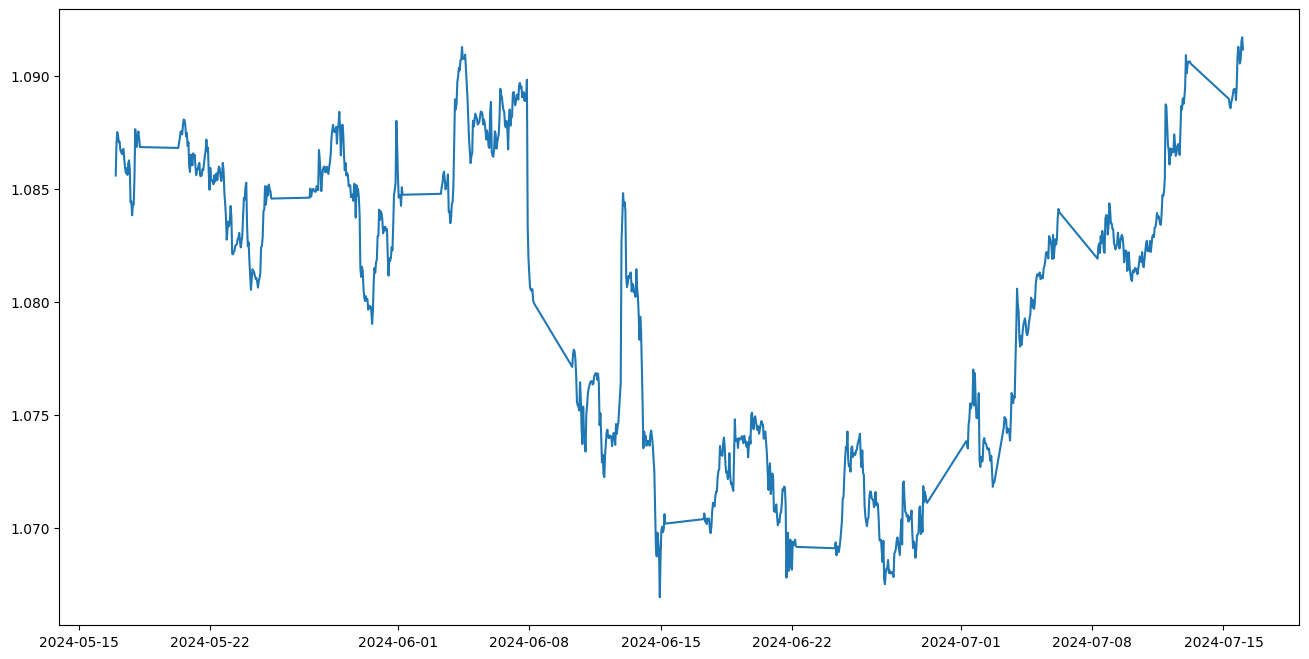

In [3]:
# Phân tích giá đóng cửa từ dataframe
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date'].values

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [4]:
# Sắp xếp dữ liệu theo thứ tự ngày tăng dần và lấy ra 2 cột Date và Close

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset.loc[i, "Date"]=data['Date'].iloc[i]
    new_dataset.loc[i, "Close"]=data["Close"].iloc[i]

print(new_dataset.head())


                  Date    Close
0  2024-05-16 23:00:00  1.08559
1  2024-05-17 00:00:00  1.08702
2  2024-05-17 01:00:00  1.08751
3  2024-05-17 02:00:00  1.08734
4  2024-05-17 03:00:00  1.08706


In [5]:
# Chuẩn hóa dữ liệu
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:800,:]
valid_data=final_dataset[800:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

d:\Apps\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [6]:
# Dựng và huấn luyện mô hình XGBoost
model=xgb.XGBRegressor()

x_train_data = x_train_data.reshape(x_train_data.shape[0], x_train_data.shape[1])
model.fit(x_train_data,y_train_data)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
# Lấy mẫu từ dữ liệu để đưa ra dự đoán giá cổ phiếu bằng mô hình RNN:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1]))
closing_price=model.predict(X_test)
closing_price=closing_price.reshape(-1, 1)
closing_price=scaler.inverse_transform(closing_price)

In [8]:
# Lưu mô hình XGBoost
model.save_model("saved_xgboost_model.json")

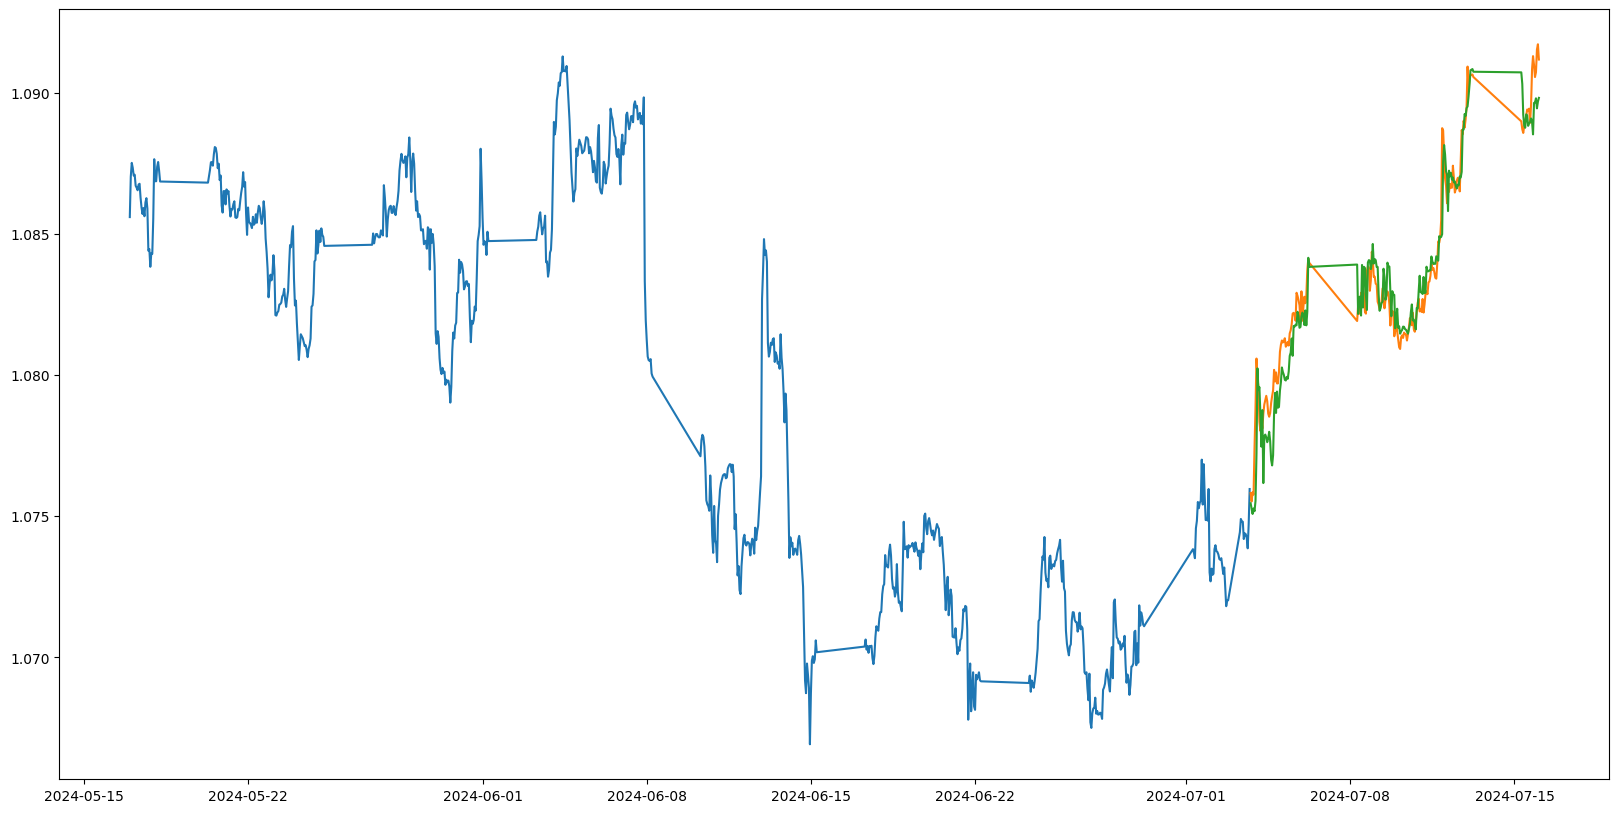

In [9]:
# Vẽ biểu đồ giá cổ phiếu dự đoán và thực tế
train_data=new_dataset[:800]
valid_data=new_dataset[800:].copy()
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
print(end = '')